In [1]:
import os
os.chdir('..')

# IMPORTS

In [2]:
import matplotlib
from matplotlib import rcParams, cycler

# matplotlib.use('Agg')
CUDA_VISIBLE_DEVICES = ""
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import random
import json
import copy
import torch
import sklearn
from itertools import cycle
from torch import nn
import os

from bernn.utils.pool_metrics import get_PCC, get_qc_euclidean, get_batches_euclidean, get_euclidean
from scipy.spatial.distance import cdist, pdist

from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from umap.umap_ import UMAP

# from bernn.utils.pool_metrics import log_pool_metrics
from bernn.utils.batch_effect_removal import get_berm  # , remove_batch_effect
from bernn.dl.models.pytorch.aedann import ReverseLayerF
from bernn.dl.models.pytorch.aedann import Encoder2, Decoder2, Classifier, Classifier2, Classifier3, DispAct, MeanAct
from bernn.dl.models.pytorch.utils.loggings import TensorboardLoggingAE, log_input_ordination, \
    log_confusion_matrix, log_plots
from bernn.dl.models.pytorch.utils.dataset import get_loaders
from bernn.utils.utils import scale_data, get_unique_labels
from bernn.dl.models.pytorch.utils.utils import get_optimizer, to_categorical, get_empty_dicts, get_empty_traces, \
    log_traces, get_best_loss_from_tb, get_best_acc_from_tb, get_best_values, add_to_logger
from bernn.dl.models.pytorch.utils.plotting import confidence_ellipse
from bernn.dl.models.pytorch.utils.stochastic import GaussianSample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


import warnings
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from tabulate import tabulate

warnings.filterwarnings("ignore")

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

strategy = 'no'
csv_name = 'proteome_log_cancers_df.csv'
bad_batches = ''
remove_zeros = 0
log_stuff = True
best_correction = False
n_meta = 0
train_models = True
log_plots = True

/home/ubuntu/simonp/BERNN_MSMS/.conda/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/simonp/BERNN_MSMS/.conda/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/simonp/BERNN_MSMS/.conda/lib/python3.8/site-packages/

In [3]:
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
rfc_space = [
    # Integer(100, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Integer(1, 100, 'uniform', name="max_features"),
    Integer(2, 10, 'uniform', name="min_samples_split"),
    Integer(1, 10, 'uniform', name="min_samples_leaf"),
    Integer(1, 1000, 'uniform', name="n_estimators"),
    Categorical(['gini', 'entropy'], name="criterion"),
    Categorical([True, False], name="oob_score"),
    Categorical(['balanced'], name="class_weight"),
]
linsvc_space = [
    # Integer(1, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Real(1e-4, 1, 'log-uniform', name='tol'),
    Integer(1, 1000, 'uniform', name='max_iter'),
    Categorical(['l2'], name='penalty'),
    Real(1e-3, 10000, 'uniform', name='C'),
    Categorical(['balanced'], name='class_weight'),

]
logreg_space = [
    # Integer(1, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Integer(1, 20000, 'uniform', name='max_iter'),
    Real(1e-3, 20000, 'uniform', name='C'),
    Categorical(['saga'], name='solver'),
    Categorical(['l1', 'l2'], name='penalty'),
    Categorical([True, False], name='fit_intercept'),
    Categorical(['balanced'], name='class_weight'),
]


In [4]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
def pyGPCA(data, group, name, metrics):
    gPCA = importr('gPCA')

    newdata = robjects.r.matrix(robjects.FloatVector(np.array(data['inputs'][group]).reshape(-1)), nrow=data['inputs'][group].shape[0])
    new_batches = robjects.r.matrix(robjects.IntVector(data['batches'][group]), nrow=data['inputs'][group].shape[0])

    results = gPCA.gPCA_batchdetect(newdata, new_batches)
    # print(results)
    # with localconverter(robjects.default_converter + pandas2ri.converter):
    #     results = np.array(robjects.conversion.rpy2py(results))
    # print(results)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        results = { key : np.array(robjects.conversion.rpy2py(results.rx2(key))) for key in results.names }
        # metrics['raw']['delta'] = metrics['raw']['delta']))

    if 'pool' in name:
        delta_name = 'delta_pool'
        name = name.split('_')[1]
    else:
        delta_name = 'delta'
    if name not in metrics:
        metrics[name] = {}
        # print(results)
    metrics[name][delta_name] = results['delta'][0]
    # metrics[name]['delta.pval'] = results[1]
    return metrics, results

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
standard_minmax_scaler = Pipeline([('standard', StandardScaler()), ('minmax', MinMaxScaler())])
robust_minmax_scaler = Pipeline([('robust', RobustScaler()), ('minmax', MinMaxScaler())])


In [6]:
import copy

def log_ORD(ordin, data, uniques, epoch, transductive=True):
    model = ordin['model']
    data = copy.deepcopy(data)
    for f in ['inputs', 'batches', 'labels']:
        for g in ['train', 'valid', 'test']:
            print(f"{f} {g}")
    if transductive:
        model.fit(np.concatenate((data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'])))
        pcs_train = model.transform(data['inputs']['train'])
        if "transductive" not in ordin['name']:
            ordin['name'] += "_transductive"
    else:
        pcs_train = model.fit_transform(data['inputs']['train'])
    if data['inputs']['valid'] is not None:
        pcs_valid = model.transform(data['inputs']['valid'])
    else:
        pcs_valid = np.array([])
    if data['inputs']['test'] is not None:
        pcs_test = model.transform(data['inputs']['test'])
    else:
        pcs_test = np.array([])
        test_labels = np.array([])
    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['PC 1', 'PC 2'])
    pcs_valid_df = pd.DataFrame(data=pcs_valid, columns=['PC 1', 'PC 2'])
    pcs_test_df = pd.DataFrame(data=pcs_test, columns=['PC 1', 'PC 2'])
    try:
        ev = model.explained_variance_ratio_
        pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
        pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
    except:
        pc1 = 'Component_1'
        pc2 = 'Component_2'

    for name in list(uniques.keys()):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.set_xlabel(pc1, fontsize=20)
        ax.set_ylabel(pc2, fontsize=20)
        # ax.set_title(f"2 component {ordin['name']} {name}", fontsize=20)

        # plt.show()

        num_targets = len(uniques[name])
        cmap = plt.cm.tab20

        cols = cmap(np.linspace(0, 1, len(uniques[name]) + 1))
        colors = rcParams['axes.prop_cycle'] = cycler(color=cols)
        colors_list = {name: [] for name in ['train', 'valid', 'test']}
        data1_list = {name: [] for name in ['train', 'valid', 'test']}
        data2_list = {name: [] for name in ['train', 'valid', 'test']}
        new_labels = {name: [] for name in ['train', 'valid', 'test']}
        new_cats = {name: [] for name in ['train', 'valid', 'test']}

        ellipses = []
        unique_cats_train = np.array([])
        for df_name, df, labels in zip(['train', 'valid', 'test'],
                                       [pcs_train_df, pcs_valid_df, pcs_test_df],
                                       [data[name]['train'], data[name]['valid'], data[name]['test']]):
            for t, target in enumerate(uniques[name]):
                indices_to_keep = [True if x == target else False for x in list(labels)]
                data1 = list(df.loc[indices_to_keep, 'PC 1'])
                new_labels[df_name] += [target for _ in range(len(data1))]
                new_cats[df_name] += [target for _ in range(len(data1))]

                data2 = list(df.loc[indices_to_keep, 'PC 2'])
                data1_list[df_name] += [data1]
                data2_list[df_name] += [data2]
                colors_list[df_name] += [np.array([[cols[t]] * len(data1)])]
                if len(indices_to_keep) > 1 and df_name == 'train_data' or target not in unique_cats_train:
                    unique_cats_train = np.unique(np.concatenate((new_labels[df_name], unique_cats_train)))
                    try:
                        confidence_ellipses = confidence_ellipse(np.array(data1), np.array(data2), ax, 1.5,
                                                                 edgecolor=cols[t],
                                                                 train_set=True)
                        ellipses += [confidence_ellipses[1]]
                    except:
                        pass

        for df_name, marker in zip(list(data1_list.keys()), ['o', 'x', '*']):
            data1_vector = np.hstack([d for d in data1_list[df_name] if len(d) > 0]).reshape(-1, 1)
            colors_vector = np.hstack([d for d in colors_list[df_name] if d.shape[1] > 0]).squeeze()
            data2_vector = np.hstack(data2_list[df_name]).reshape(-1, 1)
            data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
            data2 = data_colors_vector[:, 1]
            col = data_colors_vector[:, 2:]
            data1 = data_colors_vector[:, 0]

            ax.scatter(data1, data2, s=50, alpha=1.0, c=col, label=new_labels[df_name], marker=marker)
            custom_lines = [Line2D([0], [0], color=cmap(x), lw=4) for x in np.linspace(0, 1, len(uniques[name]) + 1)]
            if 'pool' in uniques[name]:
                uniques[name][np.argwhere(uniques[name] == 'pool')] = 'QC'
            
            if len(custom_lines) < 24:
                ax.legend(custom_lines, uniques[name].tolist(), fontsize=10)
            # print(data1)

        plt.show()
        plt.close()



In [7]:
def log_LDA(ordin, data, uniques, epoch, metrics, model_name):
    for name in list(uniques.keys()):
        skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
        train_nums = np.arange(0, len(data['labels']['all']))
        scores = []
        # Remove samples from unwanted batches
        for i, (train_inds, valid_inds) in enumerate(skf.split(train_nums, data['labels']['all'], data['batches']['all'])):

            if len(uniques[name]) > 2:
                n_comp = 2
            else:
                n_comp = 1
            model = ordin(n_components=n_comp)
            
            pcs_train = model.fit_transform(data['inputs']['all'][train_inds], data[name]['all'][train_inds])
            pcs_valid = model.transform(data['inputs']['all'][valid_inds])
            scores += [model.score(data['inputs']['all'][valid_inds], data[name]['all'][valid_inds])]
            if i == 0:
                fig = plt.figure(figsize=(12, 12))
                ax = fig.add_subplot(111)
                # pcs_train = model.transform(np.concatenate((data['inputs']['train'], data['inputs']['train_pool']), 0))
                # pcs_valid = model.transform(np.concatenate((data['inputs']['valid'], data['inputs']['valid_pool']), 0))
                # pcs_test = model.transform(np.concatenate((data['inputs']['test'], data['inputs']['test_pool']), 0))

                if n_comp > 1:
                    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['LD1', 'LD2'])
                    pcs_valid_df = pd.DataFrame(data=pcs_valid, columns=['LD1', 'LD2'])
                    # pcs_test_df = pd.DataFrame(data=pcs_test, columns=['LD1', 'LD2'])
                else:
                    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['LD1'])
                    pcs_valid_df = pd.DataFrame(data=pcs_valid, columns=['LD1'])
                    # pcs_test_df = pd.DataFrame(data=pcs_test, columns=['LD1'])

                try:
                    ev = model.explained_variance_ratio_
                    pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
                    pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
                except:
                    pc1 = 'Component_1'
                    pc2 = 'Component_2'

                ax.set_xlabel(pc1, fontsize=15)
                ax.set_ylabel(pc2, fontsize=15)
                ax.set_title(f"2 component LDA", fontsize=20)

                num_targets = len(uniques[name])
                cmap = plt.cm.tab20

                cols = cmap(np.linspace(0, 1, len(uniques[name]) + 1))
                colors = rcParams['axes.prop_cycle'] = cycler(color=cols)
                colors_list = {name: [] for name in ['train_data', 'valid_data']}
                data1_list = {name: [] for name in ['train_data', 'valid_data']}
                data2_list = {name: [] for name in ['train_data', 'valid_data']}
                new_labels = {name: [] for name in ['train_data', 'valid_data']}
                new_cats = {name: [] for name in ['train_data', 'valid_data']}

                ellipses = []
                unique_cats_train = np.array([])

                for df_name, df, labels in zip(['train_data', 'valid_data'],
                                               [pcs_train_df, pcs_valid_df],
                                               [data[name]['all'][train_inds], data[name]['all'][valid_inds]]):
                    for t, target in enumerate(uniques[name]):
                        indices_to_keep = [True if x == target else False for x in
                                           list(labels)]  # 0 is the name of the column with target values
                        data1 = list(df.loc[indices_to_keep, 'LD1'])
                        new_labels[df_name] += [target for _ in range(len(data1))]
                        new_cats[df_name] += [target for _ in range(len(data1))]

                        data1_list[df_name] += [data1]
                        colors_list[df_name] += [np.array([[cols[t]] * len(data1)])]
                        if n_comp > 1:
                            data2 = list(df.loc[indices_to_keep, 'LD2'])
                            data2_list[df_name] += [data2]
                        # if len(indices_to_keep) > 1 and df_name == 'all_data' or target not in unique_cats_train:
                        unique_cats_train = np.unique(np.concatenate((new_labels[df_name], unique_cats_train)))
                        if n_comp > 1:
                            try:
                                confidence_ellipses = confidence_ellipse(np.array(data1), np.array(data2), ax, 1.5,
                                                                         edgecolor=cols[t],
                                                                         train_set=True)
                                ellipses += [confidence_ellipses[1]]
                            except:
                                pass

                for df_name, marker in zip(list(data1_list.keys()), ['o', '*']):
                    data1_vector = np.hstack([d for d in data1_list[df_name] if len(d) > 0]).reshape(-1, 1)
                    colors_vector = np.hstack([d for d in colors_list[df_name] if d.shape[1] > 0]).squeeze()
                    if n_comp > 1:
                        data2_vector = np.hstack(data2_list[df_name]).reshape(-1, 1)
                        data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
                        data1 = data_colors_vector[:, 0]
                        data2 = data_colors_vector[:, 1]
                        col = data_colors_vector[:, 2:]
                        ax.scatter(data1, data2, s=50, alpha=1.0, c=col, label=new_labels[df_name], marker=marker)
                    else:
                        data_colors_vector = np.concatenate((data1_vector, colors_vector), axis=1)
                        data1 = data_colors_vector[:, 0]
                        col = data_colors_vector[:, 1:]
                        ax.scatter(data1, np.random.random(len(data1)), s=50, alpha=1.0, c=col, label=new_labels[df_name],
                                   marker=marker)

                    custom_lines = [Line2D([0], [0], color=cmap(x), lw=4) for x in np.linspace(0, 1, len(uniques[name]) + 1)]
                    ax.legend(custom_lines, uniques[name].tolist())

                plt.show()
                plt.close()
                plt.close()
        metrics[model_name][f'LDA_score_{name}'] = np.mean(scores)

    return metrics


In [8]:
def log_CCA(ordin, data, unique_cats, epoch):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)

    model = ordin['model']

    try:
        train_cats = OneHotEncoder().fit_transform(np.stack([np.argwhere(unique_cats == x) for x in train_labels]).reshape(-1, 1)).toarray()
    except:
        pass
    # test_cats = [np.argwhere(unique_cats == x) for x in test_labels]
    # inference_cats = [np.argwhere(unique_cats == x) for x in inference_labels]

    pcs_train, _ = model.fit_transform(data['inputs']['train'], data['cats']['train'])
    pcs_test = model.transform(data['inputs']['valid'])
    pcs_inference = model.transform(data['inputs']['test'])

    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['PC 1', 'PC 2'])
    pcs_test_df = pd.DataFrame(data=pcs_test, columns=['PC 1', 'PC 2'])
    pcs_inference_df = pd.DataFrame(data=pcs_inference, columns=['PC 1', 'PC 2'])
    try:
        ev = model.explained_variance_ratio_
        pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
        pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
    except:
        pc1 = 'Component_1'
        pc2 = 'Component_2'

    ax.set_xlabel(pc1, fontsize=15)
    ax.set_ylabel(pc2, fontsize=15)
    ax.set_title(f"2 component {ordin['name']}", fontsize=20)

    num_targets = len(unique_cats)
    cmap = plt.cm.tab20

    cols = cmap(np.linspace(0, 1, len(unique_cats) + 1))
    colors = rcParams['axes.prop_cycle'] = cycler(color=cols)
    colors_list = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    data1_list = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    data2_list = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    new_labels = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    new_cats = {name: [] for name in ['train_data', 'valid_data', 'test_data']}

    ellipses = []
    unique_cats_train = np.array([])
    for df_name, df, labels in zip(['train_data', 'valid_data', 'test_data'],
                                   [pcs_train_df, pcs_test_df, pcs_inference_df],
                                   [data['labels']['train'], data['labels']['valid'], data['labels']['test']]):
        for t, target in enumerate(unique_cats):
            # final_labels = list(train_labels)
            indices_to_keep = [True if x == target else False for x in
                               list(labels)]  # 0 is the name of the column with target values
            data1 = list(df.loc[indices_to_keep, 'PC 1'])
            new_labels[df_name] += [target for _ in range(len(data1))]
            new_cats[df_name] += [target for _ in range(len(data1))]

            data2 = list(df.loc[indices_to_keep, 'PC 2'])
            data1_list[df_name] += [data1]
            data2_list[df_name] += [data2]
            colors_list[df_name] += [np.array([[cols[t]] * len(data1)])]
            if len(indices_to_keep) > 1 and df_name == 'train_data' or target not in unique_cats_train:
                unique_cats_train = np.unique(np.concatenate((new_labels[df_name], unique_cats_train)))
                try:
                    confidence_ellipses = confidence_ellipse(np.array(data1), np.array(data2), ax, 1.5,
                                                             edgecolor=cols[t],
                                                             train_set=True)
                    ellipses += [confidence_ellipses[1]]
                except:
                    pass

    for df_name, marker in zip(list(data1_list.keys()), ['o', 'x', '*']):
        data1_vector = np.hstack([d for d in data1_list[df_name] if len(d) > 0]).reshape(-1, 1)
        colors_vector = np.hstack([d for d in colors_list[df_name] if d.shape[1] > 0]).squeeze()
        data2_vector = np.hstack(data2_list[df_name]).reshape(-1, 1)
        data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
        data2 = data_colors_vector[:, 1]
        col = data_colors_vector[:, 2:]
        data1 = data_colors_vector[:, 0]

        ax.scatter(data1, data2, s=50, alpha=1.0, c=col, label=new_labels[df_name], marker=marker)
        custom_lines = [Line2D([0], [0], color=cmap(x), lw=4) for x in np.linspace(0, 1, len(unique_cats) + 1)]
        if len(custom_lines) < 24:
            ax.legend(custom_lines, unique_cats.tolist())

    fig.savefig(f'{ordin["name"]}.png')
    plt.close()



In [9]:
def log_pool_metrics(data, batches, metrics, form):
    metric = {}

    for group in ['all']:
        if 'pool' not in group:
            try:
                data[group] = data[group].to_numpy()
                # data[f'{group}_pool'] = data[f'{group}_pool'].to_numpy()
            except:
                pass

            metric[group] = {}
            # metric[f'{group}_pool'] = {}
            batch_train_samples = [[i for i, batch in enumerate(batches[group].tolist()) if batch == b] for b in
                                   np.unique(batches[group])]
            batch_pool_samples = [[i for i, batch in enumerate(batches[f"{group}_pool"].tolist()) if batch == b] for b in
                                  np.unique(batches[f"{group}_pool"])]

            batches_sample_indices = {
                group: batch_train_samples,
                # f'{group}_pool': batch_pool_samples,
            }
            # Average Pearson's Correlation Coefficients
            try:
                metric = get_PCC(data, batches, group, metric)
            except:
                pass

            # Batch avg distance
            try:
                metric = get_batches_euclidean(data, batches_sample_indices, cdist, group, metric)
            except:
                pass

            # avg distance
            try:
                metric = get_euclidean(data, pdist, group, metric)
            except:
                pass

        # metrics[f'pool_metrics_{form}'] = metric
    if form not in metrics:
        metrics[form] = {}
    for m in metric:
        metrics[form][m] = metric[m]

    return metrics


In [10]:
def batch_entropy(proba):
    prob_list = []
    for prob in proba:
        loc = 0
        for p in prob:
            loc -= p * np.log(p + 1e-8)
        prob_list += [loc]
    return np.mean(prob_list)

In [11]:
from scipy.stats import entropy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score

def get_metrics(data, metrics, form):
    # sets are grouped togheter for a single metric
    knns = {repres: KNeighborsClassifier(n_neighbors=30) for repres in ['domains', 'labels']}
    # values = {group: {m : {'labels': [], 'domains': []} for m in ['lisi', 'kbet', 'silhouette', 'adjusted_rand_score', 'adjusted_mutual_info_score']} 
    #           for group in ['train', 'valid', 'test', 'all', 'all_pool', 'train_pool', 'valid_pool', 'test_pool']}

    if form not in metrics:
        metrics[form] = {}
    for group in ['all']:
        # metrics[group] = {m : {'labels': [], 'domains': []} for m in ['lisi', 'kbet', 'silhouette', 'adjusted_rand_score', 'adjusted_mutual_info_score']} 
        # print(group)
        if group not in metrics[form]:
            metrics[form][group] = {}

        if group == 'all':
            knns['domains'].fit(data['inputs'][group], data['batches'][group])
            knns['labels'].fit(data['inputs'][group], data['cats'][group])
        if 'pool' not in group or 'all_pool' == group:
            for metric, funct in zip(['lisi', 'silhouette', 'kbet'], [rLISI, silhouette_score, rKBET]):
                metrics[form][group][metric] = {'labels': None, 'domains': None}
                metrics[form][group][metric]['domains'] = funct(data['inputs'][group], data['batches'][group])
                if 'pool' not in group:
                    metrics[form][group][metric]['labels'] = funct(data['inputs'][group], data['cats'][group])

            domain_preds = knns['domains'].predict(data['inputs'][group].values)
            metrics[form][group]['shannon'] = {'labels': None, 'domains': None}
            # print(knns['domains'].predict_proba(data['inputs'][group]))
            metrics[form][group]['shannon']['domains'] = batch_entropy(knns['domains'].predict_proba(data['inputs'][group].values))
            if 'pool' not in group:
                labels_preds = knns['labels'].predict(data['inputs'][group].values)
                metrics[form][group]['shannon']['labels'] = batch_entropy(knns['labels'].predict_proba(data['inputs'][group].values))

            for metric, funct in zip(
                    ['adjusted_rand_score', 'adjusted_mutual_info_score'],
                    [adjusted_rand_score, adjusted_mutual_info_score]):
                metrics[form][group][metric] = {'labels': None, 'domains': None}
                metrics[form][group][metric]['domains'] = funct(data['batches'][group], domain_preds)
                if 'pool' not in group:
                    metrics[form][group][metric]['labels'] = funct(data['batches'][group], labels_preds)

    return metrics


In [12]:
def batch_f1_score(batch_score, class_score):
    return 2 * (1 - batch_score) * (class_score) / (1 - batch_score + class_score)

def log_metrics(data, unique_labels, batches, metrics, form, device='cuda'):
    unique_batches = set(batches['all'])
    if len(unique_labels) > 2:
        bout = 0
    else:
        bout = 1
    if form not in metrics:
        metrics[form] = {}
    metrics = get_metrics(data, metrics, form)
    for repres in ['inputs']:
        for metric in ['silhouette', 'kbet', 'lisi']:
            for group in ['all']:

                if metric == 'lisi':
                    try:
                        metrics[form][group][metric]['F1'] = batch_f1_score(
                            batch_score=metrics[form][group][metric]['domains'][0] / len(unique_batches),
                            class_score=metrics[form][group][metric]['labels'][0] / len(unique_labels),
                        )
                    except:
                        metrics[form][group][metric]['F1'] = batch_f1_score(
                            batch_score=metrics[form][group][metric]['domains'] / len(unique_batches),
                            class_score=metrics[form][group][metric]['labels'] / len(unique_labels),
                        )

                elif metric == 'silhouette':
                    metrics[form][group][metric]['F1'] = batch_f1_score(
                        batch_score=(metrics[form][group][metric]['domains'] + 1) / 2,
                        class_score=(metrics[form][group][metric]['labels'] + 1) / 2,
                    )
                elif metric == 'kbet':
                    try:
                        metrics[form][group][metric]['F1'] = batch_f1_score(
                            batch_score=metrics[form][group][metric]['domains'] / len(unique_batches),
                            class_score=metrics[form][group][metric]['labels'] / len(unique_labels),
                        )
                    except:
                        pass

    for repres in ['inputs']:
        for metric in ['adjusted_rand_score', 'adjusted_mutual_info_score']:
            for group in ['all']:  # , 'set'
                try:
                    metrics[form][group][metric]['F1'] = batch_f1_score(
                        batch_score=metrics[form][group][metric]['domains'],
                        class_score=metrics[form][group][metric]['labels'],
                    )
                except:
                    metrics[form][group][metric]['F1'] = -1

    return metrics




In [13]:

def use_pycombat(berm, data):
    df = pd.concat((
        data['inputs']['train'].copy(),  data['inputs']['valid'].copy(), data['inputs']['test'].copy(), 
        # data['inputs']['train_pool'].copy(),  data['inputs']['valid_pool'].copy(), data['inputs']['test_pool'].copy(), 
    ))
    all_batches = np.concatenate((
        data['batches']['train'], data['batches']['valid'], data['batches']['test'],
        # data['batches']['train_pool'], data['batches']['valid_pool'], data['batches']['test_pool'],
    ))
    # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
    tmp = berm(df.T, all_batches).T
    tmp = np.nan_to_num(tmp, 0)
    previous_len = 0
    for g in ['train', 'valid', 'test']:
        # print(g, previous_len, data['inputs'][g].shape[0])
        data['inputs'][g] = pd.DataFrame(
            tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
            index=data['inputs'][g].index)
        previous_len += data['inputs'][g].shape[0]
        # print(g, previous_len, data['inputs'][g].shape[0])
    data['inputs']['all'] = pd.concat((
        data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'],
        # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
    ), 0)
    # data['inputs']['all_pool'] = pd.concat((
    #     data['inputs']['train_pool'], data['inputs']['valid_pool'], data['inputs']['test_pool'],
    # ), 0)

    return data

def remove_batch_effect(berm, data):
    """
    All dataframes have a shape of N samples (rows) x M features (columns)

    Args:
        berm: Batch effect removal method
        all_data: Pandas dataframe containing all data (train, valid and test data)
        data: list of Pandas dataframe containing the training data. Used only to get
        valid_data: Pandas dataframe containing the validation data
        test_data: Pandas dataframe containing the test data
        all_batches: A list containing the batch ids corresponding to all_data

    Returns:
        Returns:
        A dictionary of pandas datasets corrected for batch effect with keys:
            'all': Pandas dataframe containing all data (train, valid and test data)
            'train': Pandas dataframe containing the training data
            'valid': Pandas dataframe containing the validation data
            'test: Pandas dataframe containing the test data

    """
    if berm is not None:  # Look if has 20 before and after
        df = pd.concat((
            data['inputs']['train'].copy(),  data['inputs']['valid'].copy(), data['inputs']['test'].copy(),
        ))
        all_batches = np.concatenate((
            data['batches']['train'], data['batches']['valid'], data['batches']['test']

        ))
        # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
        tmp = berm(df, all_batches)
        inputs_len = data['inputs']['train'].shape[0] + data['inputs']['train'].shape[0] + data['inputs']['valid'].shape[0] + \
                        data['inputs']['valid'].shape[0] + data['inputs']['test'].shape[0] + data['inputs']['test'].shape[0]
        previous_len = 0
        for g in ['train', 'valid', 'test']:
            if 'all' in g:
                continue
            print(g, previous_len)
            data['inputs'][g] = pd.DataFrame(
                tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
                index=data['inputs'][g].index)
            previous_len += data['inputs'][g].shape[0]
        data['inputs']['all'] = pd.concat((
            data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'],
            # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
        ), 0)

    return data

def remove_batch_effect_with_classes(berm, data, classes):
    """
    All dataframes have a shape of N samples (rows) x M features (columns)

    Args:
        berm: Batch effect removal method
        all_data: Pandas dataframe containing all data (train, valid and test data)
        data: list of Pandas dataframe containing the training data. Used only to get
        valid_data: Pandas dataframe containing the validation data
        test_data: Pandas dataframe containing the test data
        all_batches: A list containing the batch ids corresponding to all_data

    Returns:
        Returns:
        A dictionary of pandas datasets corrected for batch effect with keys:
            'all': Pandas dataframe containing all data (train, valid and test data)
            'train': Pandas dataframe containing the training data
            'valid': Pandas dataframe containing the validation data
            'test: Pandas dataframe containing the test data

    """
    if berm is not None:  # Look if has 20 before and after
        df = pd.concat((
            data['inputs']['train'].copy(), data['inputs']['valid'].copy(), data['inputs']['test'].copy()
        ))
        all_batches = np.concatenate((
            data['batches']['train'], data['batches']['valid'], data['batches']['test']
        ))
        # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
        tmp = berm(df, all_batches, classes)
        inputs_len = data['inputs']['train'].shape[0] + data['inputs']['valid'].shape[0] + data['inputs']['test'].shape[0]
        previous_len = 0
        for g in list(data['inputs'].keys()):
            if 'all' in g:
                continue
            print(g, previous_len)
            data['inputs'][g] = pd.DataFrame(
                tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
                index=data['inputs'][g].index)
            previous_len += data['inputs'][g].shape[0]
        try:
            data['inputs']['all'] = pd.DataFrame(tmp, index=df.index, columns=df.columns)
        except:
            data['inputs']['all'] = pd.DataFrame(tmp, index=df.index)

    return data



In [14]:
def save_confusion_matrix(fig, name, acc, mcc, group):
    # sns_plot = sns.heatmap(df, annot=True, square=True, cmap="YlGnBu",
    #                        annot_kws={"size": 35 / np.sqrt(len(df))})
    # fig = sns_plot.get_figure()
    dirs = '/'.join(name.split('/')[:-1])
    name = name.split('/')[-1]
    plt.title(f'Confusion Matrix (acc={np.round(np.mean(acc), 2)} +- {np.round(np.std(acc), 2)}, mcc={np.round(np.mean(mcc), 2)} +- {np.round(np.std(mcc), 2)})')
    os.makedirs(f'{dirs}/', exist_ok=True)
    stuck = True
    while stuck:
        try:
            fig.savefig(f"{dirs}/cm_{name}_{group}.png")
            stuck = False
        except:
            print('stuck...')
    plt.close()



In [15]:
from skopt import gp_minimize
from bernn.ml.train.sklearn_train_nocv import count_labels, get_confusion_matrix, save_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.multiclass import OneVsRestClassifier
# from sklearn import metrics
from sklearn.metrics import roc_auc_score
from bernn.utils.utils import plot_confusion_matrix

class Train:
    def __init__(self, name, model, data, hparams_names, log_path, args, logger, ovr, model_name='RF', binary=True, mlops='None'):
        self.best_roc_score = -1
        self.ovr = ovr
        self.binary = binary
        self.args = args
        self.log_path = log_path
        self.model = model
        self.model_name = model_name
        self.data = data
        self.logger = logger
        self.hparams_names = hparams_names
        # self.train_indices, self.test_indices, _ = split_train_test(self.labels)
        # self.n_splits = args.n_splits
        # self.n_repeats = args.n_repeats
        # self.jackknife = args.jackknife
        self.best_scores_train = -1
        self.best_scores_valid = -1
        self.best_mccs_train = -1
        self.best_mccs_valid = -1
        self.scores_train = None
        self.scores_valid = None
        self.mccs_train = None
        self.mccs_valid = None
        self.y_preds = np.array([])
        self.y_valids = np.array([])
        self.iter = 0
        self.model = model
        self.name = name
        self.mlops = mlops
        self.best_params_dict = {}
        self.best_params_dict_values = {}

    def train(self, h_params, groupkfold=0):
        self.iter += 1
        features_cutoff = None
        param_grid = {}
        for name, param in zip(self.hparams_names, h_params):
            if name == 'features_cutoff':
                features_cutoff = param
            elif name == 'threshold':
                threshold = param
            else:
                param_grid[name] = param
        scores_valid = []
        scores_train = []
        scores_test = []
        y_preds_train = []
        y_preds_valid = []
        y_preds_test = []

        train_classes = []
        valid_classes = []
        test_classes = []
        
        mccs_train = []
        mccs_valid = []
        mccs_test = []
        all_data = data['inputs']['all']
        all_meta = data['meta']['all']
        all_labels = data['labels']['all']
        # all_names = data['names']['all']
        all_batches = data['batches']['all']
        all_cats = data['cats']['all']
        unique_labels = []
        for l in all_labels:
            if l not in unique_labels:
                unique_labels += [l]

        unique_labels = np.array(unique_labels)

        print(f'Iteration: {self.iter}')
        for h in range(5):
            if groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=h)
                train_nums = np.arange(0, len(all_labels))
                # Remove samples from unwanted batches
                train_inds, valid_inds = skf.split(train_nums, all_labels, all_batches).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
                train_nums = np.arange(0, len(all_labels))
                train_inds, valid_inds = skf.split(train_nums, all_labels).__next__()
            train_data, valid_data = all_data.iloc[train_inds], all_data.iloc[valid_inds]
            train_meta, valid_meta = all_meta.iloc[train_inds], all_meta.iloc[valid_inds]
            train_labels, valid_labels = all_labels[train_inds], all_labels[valid_inds]
            # train_names, valid_names = all_names[train_inds], all_names[valid_inds]
            train_batches, valid_batches = all_batches[train_inds], all_batches[valid_inds]
            train_cats, valid_cats = all_cats[train_inds], all_cats[valid_inds]

            if groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=h)
                train_nums = np.arange(0, len(train_labels))
                # Remove samples from unwanted batches
                train_inds, test_inds = skf.split(train_nums, train_labels, train_batches).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
                train_nums = np.arange(0, len(train_labels))
                train_inds, test_inds = skf.split(train_nums, train_labels).__next__()
            train_data, test_data = train_data.iloc[train_inds], train_data.iloc[test_inds]
            train_meta, test_meta = train_meta.iloc[train_inds], train_meta.iloc[test_inds]
            train_labels, test_labels = train_labels[train_inds], train_labels[test_inds]
            # train_names, test_names = train_names[train_inds], train_names[test_inds]
            train_batches, test_batches = train_batches[train_inds], train_batches[test_inds]
            train_cats, test_cats = train_cats[train_inds], train_cats[test_inds]

            train_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in train_labels])]
            valid_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in valid_labels])]
            test_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in test_labels])]


            m = self.model()
            m.set_params(**param_grid)
            if self.ovr:
                m = OneVsRestClassifier(m)
            # try:
            m.fit(train_data, train_classes[-1])
            # except:
            #     return 1

            scores_valid += [m.score(valid_data, valid_classes[-1])]
            scores_train += [m.score(train_data, train_classes[-1])]
            scores_test += [m.score(test_data, test_classes[-1])]
            # scores_train = score_train
            # scores_valid = score_valid

            y_preds_train += [m.predict(train_data)]
            y_preds_valid += [m.predict(valid_data)]
            y_preds_test += [m.predict(test_data)]

            mccs_train += [MCC(train_classes[-1], y_preds_train[-1])]
            mccs_valid += [MCC(valid_classes[-1], y_preds_valid[-1])]
            mccs_test += [MCC(test_classes[-1], y_preds_test[-1])]
            if self.best_scores_valid is None:
                self.best_scores_valid = 0
        print(self.best_scores_valid)
        print('valid_score:', np.mean(scores_valid), 'h_params:', param_grid)
        if np.mean(scores_valid) > np.mean(self.best_scores_valid):
            self.best_scores_train = scores_train
            self.best_scores_valid = scores_valid
            self.best_scores_test = scores_test
            self.best_mccs_train = mccs_train
            self.best_mccs_valid = mccs_valid
            self.best_mccs_test = mccs_test
            fig = get_confusion_matrix(np.concatenate(train_classes), np.concatenate(y_preds_train), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_train", 
                                  acc=scores_train, mcc=mccs_train, group='train')
            fig = get_confusion_matrix(np.concatenate(valid_classes), np.concatenate(y_preds_valid), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_valid", 
                                  acc=scores_valid, mcc=mccs_valid, group='valid')
            fig = get_confusion_matrix(np.concatenate(test_classes), np.concatenate(y_preds_test), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_test", 
                                  acc=scores_test, mcc=mccs_test, group='test')
            try:
                self.best_roc_train = save_roc_curve(m, train_data, train_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_train", binary=0,
                                                     acc=score_train)
            except:
                pass
            try:
                self.best_roc_valid = save_roc_curve(m, valid_data, valid_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_valid", binary=0,
                                                     acc=score_valid)
            except:
                pass
            try:
                self.best_roc_test = save_roc_curve(m, test_data, test_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_test", binary=0,
                                                     acc=score_test)
            except:
                pass
            self.save_best_model_hparams(self.hparams_names, param_grid)

        return 1 - np.mean(scores_valid)

    def save_best_model_hparams(self, hparams_names, params):
        param_grid = {}
        for name, param in zip(hparams_names, params):
            param_grid[name] = param
        self.best_params_dict = param_grid

        self.best_params_dict_values['train_acc'] = self.best_scores_train
        self.best_params_dict_values['valid_acc'] = self.best_scores_valid
        self.best_params_dict_values['test_acc'] = self.best_scores_test
        self.best_params_dict_values['train_acc'] = self.best_scores_train
        self.best_params_dict_values['valid_acc'] = self.best_scores_valid
        self.best_params_dict_values['test_acc'] = self.best_scores_test

        self.best_params_dict_values['train_mcc'] = self.best_mccs_train
        self.best_params_dict_values['valid_mcc'] = self.best_mccs_valid
        self.best_params_dict_values['test_mcc'] = self.best_mccs_test
        self.best_params_dict_values['train_mcc'] = self.best_mccs_train
        self.best_params_dict_values['valid_mcc'] = self.best_mccs_valid
        self.best_params_dict_values['test_mcc'] = self.best_mccs_test
        
        self.best_params_dict['train_acc_mean'] = np.mean(self.best_scores_train)
        self.best_params_dict['valid_acc_mean'] = np.mean(self.best_scores_valid)
        self.best_params_dict['test_acc_mean'] = np.mean(self.best_scores_test)
        self.best_params_dict['train_acc_std'] = np.std(self.best_scores_train)
        self.best_params_dict['valid_acc_std'] = np.std(self.best_scores_valid)
        self.best_params_dict['test_acc_std'] = np.std(self.best_scores_test)

        self.best_params_dict['train_mcc_mean'] = np.mean(self.best_mccs_train)
        self.best_params_dict['valid_mcc_mean'] = np.mean(self.best_mccs_valid)
        self.best_params_dict['test_mcc_mean'] = np.mean(self.best_mccs_test)
        self.best_params_dict['train_mcc_std'] = np.std(self.best_mccs_train)
        self.best_params_dict['valid_mcc_std'] = np.std(self.best_mccs_valid)
        self.best_params_dict['test_mcc_std'] = np.std(self.best_mccs_test)

        print(self.log_path)
        os.makedirs(f'{self.log_path}/saved_models/', exist_ok=True)
        with open(f'{self.log_path}/saved_models/best_params_{self.name}_{self.model_name}.json', "w") as read_file:
            json.dump(self.best_params_dict, read_file)
        with open(f'{self.log_path}/saved_models/best_params_{self.name}_{self.model_name}_values.json', "w") as read_file:
            json.dump(self.best_params_dict_values, read_file)




In [16]:
def train_rfc(data, name, n_meta):
    hparams_names = [x.name for x in rfc_space]
    train = Train("inputs", RandomForestClassifier, data, hparams_names,
                  f'results/multi/{csv_name.split(".")[0]}/{name}/rfc/{n_meta}', None, None, ovr=0, binary=False, mlops='None', model_name='RF')
    res = gp_minimize(train.train, rfc_space, n_calls=20, random_state=1)


In [17]:
def train_linsvc(data, name, n_meta):
    hparams_names = [x.name for x in linsvc_space]
    train = Train("inputs", sklearn.svm.LinearSVC, data, hparams_names,
                  f'results/multi/{csv_name.split(".")[0]}/{name}/linsvc/{n_meta}', None, None, ovr=0, binary=False, mlops='None', model_name='linsvc')
    res = gp_minimize(train.train, linsvc_space, n_calls=20, random_state=1)


In [18]:
from sklearn.linear_model import LogisticRegression
def train_logreg(data, name, n_meta):
    hparams_names = [x.name for x in logreg_space]
    train = Train("inputs", LogisticRegression, data, hparams_names,
                  f'results/multi/{csv_name.split(".")[0]}/{name}/logreg/{n_meta}', None, None, ovr=0, binary=False, mlops='None')
    res = gp_minimize(train.train, linsvc_space, n_calls=20, random_state=1)


In [19]:
def rLISI(data, meta_data, perplexity=10):
    import rpy2.robjects as robjects
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr
    from rpy2.robjects.conversion import localconverter
    lisi = importr('lisi')
    # all_batches_r = robjects.IntVector(all_batches[all_ranks])
    # all_data_r.colnames = robjects.StrVector([str(x) for x in range(df.shape[1])])
    # labels = ['label1', 'label2']
    labels = robjects.StrVector(['label1'])
    new_meta_data = robjects.r.matrix(robjects.IntVector(meta_data), nrow=data.shape[0])
    newdata = robjects.r.matrix(robjects.FloatVector(data.values.reshape(-1)), nrow=data.shape[0])

    new_meta_data.colnames = labels
    results = lisi.compute_lisi(newdata, new_meta_data, labels, perplexity)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        results = np.array(robjects.conversion.rpy2py(results))
    mean = np.mean(results)
    return mean  # , np.std(results), results


In [20]:
def rKBET(inputs, cats):
    kbet = importr('kBET')
    # all_batches_r = robjects.IntVector(all_batches[all_ranks])
    # all_data_r.colnames = robjects.StrVector([str(x) for x in range(df.shape[1])])
    # labels = ['label1', 'label2']
    labels = robjects.StrVector(['label1'])
    new_meta_data = robjects.IntVector(cats)
    newdata = robjects.r.matrix(robjects.FloatVector(inputs.values.reshape(-1)), nrow=inputs.shape[0])

    new_meta_data.colnames = labels
    results = kbet.kBET(newdata, new_meta_data, do_pca=False, plot=False)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        results = robjects.conversion.rpy2py(results[0])
    try:
        mean = results['kBET.signif'][0]
    except:
        mean = 0

    return mean

In [21]:
def get_data(path, args, seed=42):
    """

    Args:
        path: Path where the csvs can be loaded. The folder designated by path needs to contain at least
                   one file named train_inputs.csv (when using --use_valid=0 and --use_test=0). When using
                   --use_valid=1 and --use_test=1, it must also contain valid_inputs.csv and test_inputs.csv.

    Returns:
        data
    """
    data = {}
    unique_labels = np.array([])
    for info in ['inputs', 'meta', 'names', 'labels', 'cats', 'batches', 'orders', 'sets']:
        data[info] = {}
        for group in ['all', 'train', 'test', 'valid']:
            data[info][group] = np.array([])
    for group in ['train', 'valid']:
        # print('GROUP:', group)
        if group == 'valid':
            if args.groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train']))
                # Remove samples from unwanted batches
                splitter = skf.split(train_nums, data['labels']['train'], data['batches']['train'])

            else:
                skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train']))
                splitter = skf.split(train_nums, data['labels']['train'])

            _, valid_inds = splitter.__next__()
            _, test_inds = splitter.__next__()
            train_inds = [x for x in train_nums if x not in np.concatenate((valid_inds, test_inds))]

            data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'] = data['inputs']['train'].iloc[train_inds], \
                data['inputs']['train'].iloc[valid_inds], data['inputs']['train'].iloc[test_inds]
            data['meta']['train'], data['meta']['valid'], data['meta']['test'] = data['meta']['train'].iloc[train_inds], \
                data['meta']['train'].iloc[valid_inds], data['meta']['train'].iloc[test_inds]
            data['labels']['train'], data['labels']['valid'], data['labels']['test'] = data['labels']['train'][train_inds], \
                data['labels']['train'][valid_inds], data['labels']['train'][test_inds]
            data['names']['train'], data['names']['valid'], data['names']['test'] = data['names']['train'].iloc[train_inds], \
                data['names']['train'].iloc[valid_inds], data['names']['train'].iloc[test_inds]
            data['orders']['train'], data['orders']['valid'], data['orders']['test'] = data['orders']['train'][train_inds], \
                data['orders']['train'][valid_inds], data['orders']['train'][test_inds]
            data['batches']['train'], data['batches']['valid'], data['batches']['test'] = data['batches']['train'][train_inds], \
                data['batches']['train'][valid_inds], data['batches']['train'][test_inds]
            data['cats']['train'], data['cats']['valid'], data['cats']['test'] = data['cats']['train'][train_inds], data['cats']['train'][
                valid_inds], data['cats']['train'][test_inds]

            if args.pool:
                if args.groupkfold:
                    skf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=seed)
                    train_nums_pool = np.arange(0, len(data['labels']['train_pool']))
                    pool_splitter = skf.split(train_nums_pool, data['labels']['train_pool'],
                                                    data['batches']['train_pool'])

                else:
                    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
                    train_nums_pool = np.arange(0, len(data['labels']['train_pool']))
                    pool_splitter = skf.split(train_nums_pool, data['labels']['train_pool'])

                _, valid_inds = pool_splitter.__next__()
                _, test_inds = pool_splitter.__next__()
                train_inds = [x for x in train_nums_pool if x not in np.concatenate((valid_inds, test_inds))]
                data['inputs']['train_pool'], data['inputs']['valid_pool'], data['inputs']['test_pool'], = data['inputs']['train_pool'].iloc[train_inds], \
                    data['inputs']['train_pool'].iloc[valid_inds], data['inputs']['train_pool'].iloc[test_inds]
                data['meta']['train_pool'], data['meta']['valid_pool'], data['meta']['test_pool'], = data['meta']['train_pool'].iloc[train_inds], \
                    data['meta']['train_pool'].iloc[valid_inds], data['meta']['train_pool'].iloc[test_inds]
                data['labels']['train_pool'], data['labels']['valid_pool'], data['labels']['test_pool'], = data['labels']['train_pool'][train_inds], \
                    data['labels']['train_pool'][valid_inds], data['labels']['train_pool'][test_inds]
                data['names']['train_pool'], data['names']['valid_pool'], data['names']['test_pool'], = data['names']['train_pool'][train_inds], \
                    data['names']['train_pool'][valid_inds], data['names']['train_pool'][test_inds]
                data['orders']['train_pool'], data['orders']['valid_pool'], data['orders']['test_pool'], = data['orders']['train_pool'][train_inds], \
                    data['orders']['train_pool'][valid_inds], data['orders']['train_pool'][test_inds]
                data['batches']['train_pool'], data['batches']['valid_pool'], data['batches']['test_pool'], = data['batches']['train_pool'][train_inds], \
                    data['batches']['train_pool'][valid_inds], data['batches']['train_pool'][test_inds]
                data['cats']['train_pool'], data['cats']['valid_pool'], data['cats']['test_pool'], = data['cats']['train_pool'][train_inds], data['cats']['train_pool'][
                    valid_inds], data['cats']['train_pool'][test_inds]

        else:
            matrix = pd.read_csv(
                f"{path}/{args.csv_file}", sep=","
            )
            names = matrix.iloc[:, 0]
            labels = matrix.iloc[:, 1]
            batches = matrix.iloc[:, 2]
            unique_batches = batches.unique()
            batches = np.stack([np.argwhere(x == unique_batches).squeeze() for x in batches])
            orders = np.array([0 for _ in batches])
            matrix = matrix.iloc[:, 3:].fillna(0)
            if args.remove_zeros:
                mask1 = (matrix == 0).mean(axis=0) < 0.1
                matrix = matrix.loc[:, mask1]
            if args.log1p:
                matrix.iloc[:] = np.log1p(matrix.values)
            # pool_pos = [i for i, name in enumerate(names.values.flatten()) if 'QC' in name]
            pos = [i for i, name in enumerate(names.values.flatten()) if 'QC' not in name]
            data['inputs'][group] = matrix.iloc[pos]
            data['names'][group] = names
            data['labels'][group] = labels.to_numpy()[pos]
            data['batches'][group] = batches[pos]
            # This is juste to make the pipeline work. Meta should be 0 for the amide dataset
            data['meta'][group] = data['inputs'][group].iloc[:, :2]
            data['orders'][group] = orders[pos]

            # data['labels'][group] = np.array([x.split('-')[0] for i, x in enumerate(data['labels'][group])])
            unique_labels = get_unique_labels(data['labels'][group])
            data['cats'][group] = data['labels'][group]

            if args.pool:
                pool_pos = [i for i, name in enumerate(names.values.flatten()) if 'QC' in name]
                data['inputs'][f"{group}_pool"] = matrix.iloc[pool_pos]
                data['names'][f"{group}_pool"] = np.array([f'pool_{i}' for i, _ in enumerate(pool_pos)])
                data['labels'][f"{group}_pool"] = np.array([f'pool' for _ in pool_pos])
                data['batches'][f"{group}_pool"] = batches[pool_pos]

                # This is juste to make the pipeline work. Meta should be 0 for the amide dataset
                data['meta'][f"{group}_pool"] = data['inputs'][f"{group}_pool"].iloc[:, :2]
                data['orders'][f"{group}_pool"] = orders[pool_pos]
                data['cats'][f"{group}_pool"] = np.array(
                    [len(np.unique(data['labels'][group])) for _ in batches[pool_pos]])

                data['labels'][group] = np.array([x.split('-')[0] for i, x in enumerate(data['labels'][group])])
                unique_labels = np.concatenate((get_unique_labels(data['labels'][group]), np.array(['pool'])))
                data['cats'][group] = np.array(
                    [np.where(x == unique_labels)[0][0] for i, x in enumerate(data['labels'][group])])

    for key in list(data['names'].keys()):
        data['sets'][key] = np.array([key for _ in data['names'][key]])
        # print(key, data['sets'][key])
    if not args.pool:
        for key in list(data.keys()):
            if key in ['inputs', 'meta']:
                data[key]['all'] = pd.concat((
                    data[key]['train'], data[key]['valid'], data[key]['test']
                ), 0)
            else:
                data[key]['all'] = np.concatenate((
                    data[key]['train'], data[key]['valid'], data[key]['test']
                ), 0)
        
        unique_batches = np.unique(data['batches']['all'])
        for group in ['train', 'valid', 'test', 'all']:
            data['batches'][group] = np.array([np.argwhere(unique_batches == x)[0][0] for x in data['batches'][group]])
    else:
        # print('POOL!!')
        for key in list(data.keys()):
            # print('key', key)
            if key in ['inputs', 'meta']:
                data[key]['all'] = pd.concat((
                    data[key]['train'], data[key]['valid'], data[key]['test'],
                    data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
                ), 0)
                data[key]['all_pool'] = pd.concat((
                    data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
                ), 0)
            else:
                data[key]['all'] = np.concatenate((
                    data[key]['train'], data[key]['valid'], data[key]['test'],
                    data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
                ), 0)
                data[key]['all_pool'] = np.concatenate((
                    data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
                ), 0)

        unique_batches = np.unique(data['batches']['all'])
        for group in ['train', 'valid', 'test', 'train_pool', 'valid_pool', 'test_pool', 'all', 'all_pool']:
            data['batches'][group] = np.array([np.argwhere(unique_batches == x)[0][0] for x in data['batches'][group]])

    return data, unique_labels, unique_batches


In [22]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
def make_pval_table(data, unique_labels):
    print("Mann      pval min    n pvals < 0.05")
    table = pd.DataFrame(columns=['pval', 'n'])
    i = 0
    for i, label in enumerate(unique_labels[:-1]):
        for label2 in unique_labels[i+1:]:
            if label != label2 and label != 'pool' and label2 != 'pool':
                pvals = stats.mannwhitneyu(
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label).squeeze()], 
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label2).squeeze()]
                )
                tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
                table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
                table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
                i += 1
    print(tabulate(table))

    print('ttests')
    table = pd.DataFrame(columns=['pval'])
    i = 0
    for i, label in enumerate(unique_labels[:-1]):
        for label2 in unique_labels[i+1:]:
            if label != label2 and label != 'pool' and label2 != 'pool':
                pvals = stats.ttest_ind(
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label).squeeze()], 
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label2).squeeze()]
                )
                tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
                table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
                table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
                i += 1
    print(tabulate(table))


In [23]:
%matplotlib inline
# from src.dl.models.pytorch.utils.metrics import rLISI
# logger, lists, values, model, unique_labels, unique_batches, epoch, mlops, metrics, n_meta_emb=0, device='cuda'
def log_fct(data, unique_labels, form, metrics):
    make_pval_table(data, unique_labels)
    if log_stuff:
        # metrics, _ = pyGPCA(data, 'all_pool', 'pool_raw', metrics)
        # metrics, _ = pyGPCA(data, 'all', 'raw', metrics)
        # metrics = log_pool_metrics(data['inputs'], data['batches'], metrics, form)
        metrics = log_metrics(data, unique_labels, data['batches'], metrics, form, device='cuda')
        # for group in data['inputs']:
        #     data['inputs'][group] = pd.DataFrame(data['inputs'][group])
        # metrics = log_LDA(LDA, data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'raw')
    return metrics

def log_ord(data, unique_labels, unique_batches):
    log_ORD({'model': PCA(n_components=2), 'name': f'PCA_inputs'}, data, 
            {'batches': unique_batches, 'labels': unique_labels, 
            #'gender': unique_genders, 'age': unique_ages
            }, 0)
    log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_inputs'}, data, 
            {'batches': unique_batches, 'labels': unique_labels, 
            #'gender': unique_genders, 'age': unique_ages
            }, 0)


def train_fct(data, n_meta, train_models, form):
    if train_models:
        train_linsvc(data, form, n_meta)
        train_rfc(data, form, n_meta)
        # train_logreg(data, form, n_meta)
    

In [24]:
metrics = {}

# RAW

In [25]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.csv_file = 'proteome_log_cancers_df.csv'
args.remove_zeros = 0
args.bad_batches = ''
args.log1p = 0
args.zinb = 0
args.groupkfold = 0
args.pool = 0

path = 'data/PanCancer/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_batches

4

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


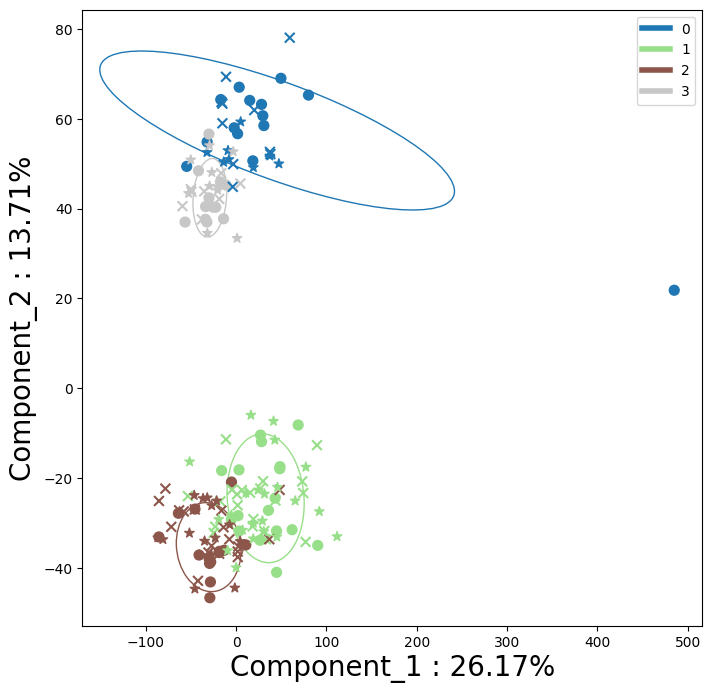

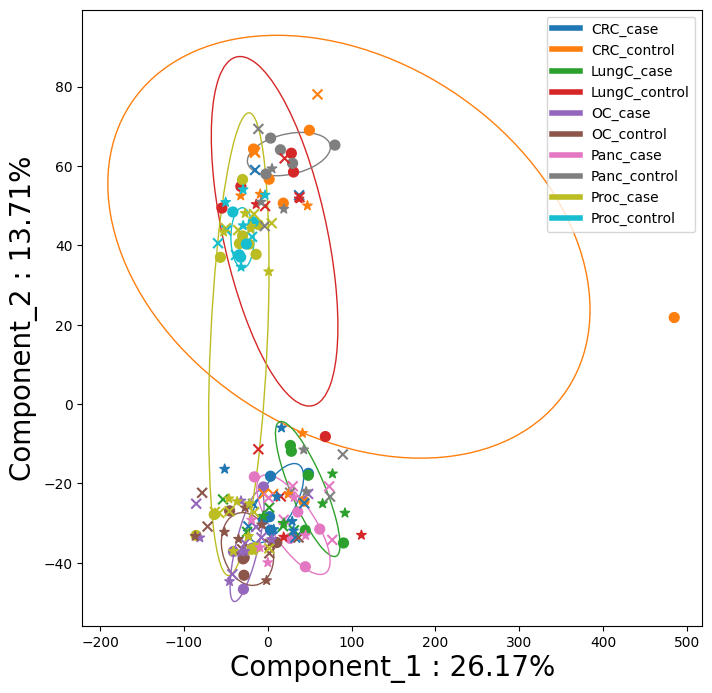

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


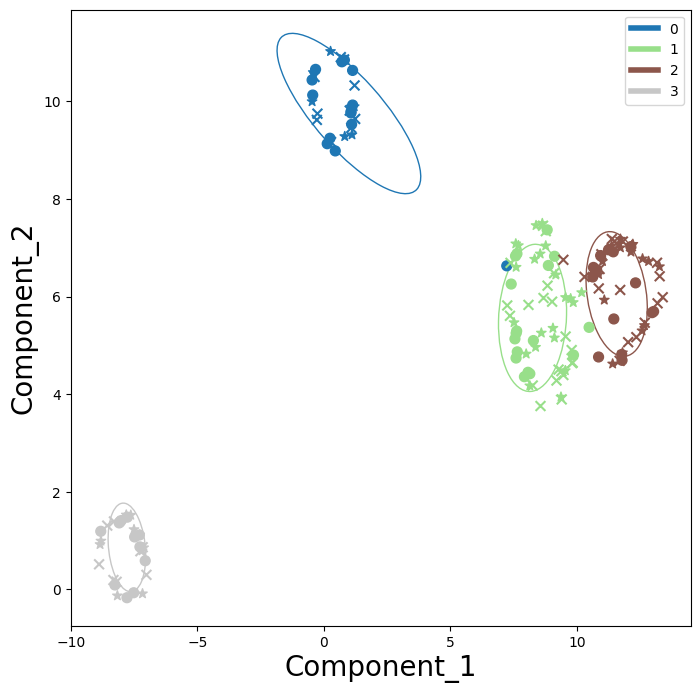

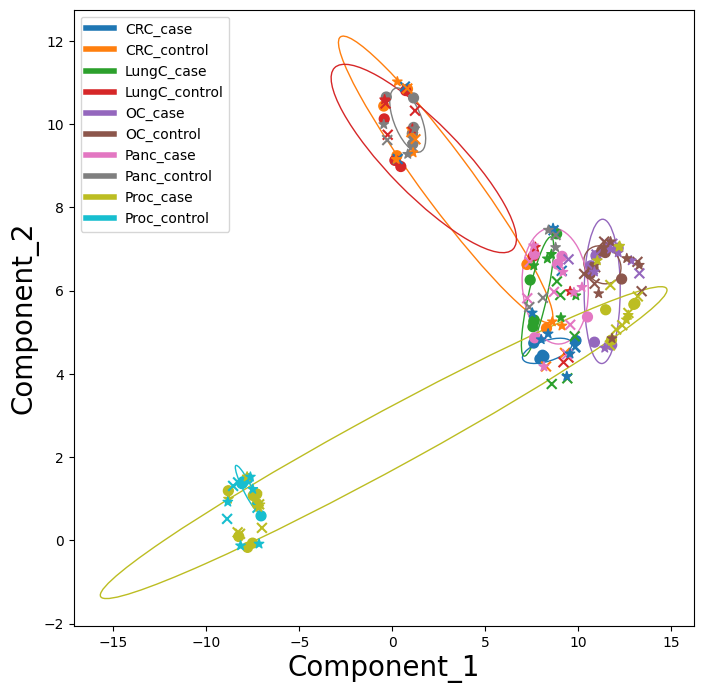

Iteration: 1
-1
valid_score: 0.48 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/multi/proteome_log_cancers_df/raw/linsvc/0
Iteration: 2
[0.45714285714285713, 0.4857142857142857, 0.4857142857142857, 0.4857142857142857, 0.4857142857142857]
valid_score: 0.45714285714285713 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.45714285714285713, 0.4857142857142857, 0.4857142857142857, 0.4857142857142857, 0.4857142857142857]
valid_score: 0.49714285714285705 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
results/multi/proteome_log_cancers_df/raw/linsvc/0
Iteration: 4
[0.5142857142857142, 0.45714285714285713, 0.45714285714285713, 0.5428571428571428, 0.5142857142857142]
valid_score: 0.48 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, '

In [26]:
%matplotlib inline
# metrics = log_fct(copy.deepcopy(data), unique_labels, 'raw', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'raw')


In [27]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    table = pd.DataFrame(columns=cols, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        # print(col, f'pool {row}', metrics[row]['all_pool'][col]["domains"])
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['all'][col]

table

,lisi,silhouette,kbet,shannon,adjusted_rand_score,adjusted_mutual_info_score


# Minmax

In [28]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('minmax', data, device='cpu')

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


FileNotFoundError: [Errno 2] No such file or directory: 'data/PXD015912//proteome_log_cancers_df.csv'

In [ ]:
len(unique_batches)

78

In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'minmax', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'minmax')


Mann      pval min    n pvals < 0.05
-------------------------------------------------------------------------------------  -----------  -----
0% ovary / 50% prostate / 50% yeast_12.5% ovary / 50% prostate / 37.5% yeast           9.67254e-63  13951
0% ovary / 50% prostate / 50% yeast_25% ovary / 50% prostate / 25% yeast               5.96447e-63  15216
0% ovary / 50% prostate / 50% yeast_3.125% ovary / 50% prostate / 46.875% yeast        2.53624e-60  11481
0% ovary / 50% prostate / 50% yeast_50% ovary / 0% prostate / 50% yeast                7.64995e-56  14226
0% ovary / 50% prostate / 50% yeast_50% ovary / 50% prostate / 0% yeast                1.3178e-56   15797
0% ovary / 50% prostate / 50% yeast_6.25% ovary / 50% prostate / 43.75% yeast          1.01515e-61  12730
0% ovary / 50% prostate / 50% yeast_hek293t control cell line                          4.8675e-58   15902
12.5% ovary / 50% prostate / 37.5% yeast_25% ovary / 50% prostate / 25% yeast          8.26925e-44  12305
12.5% ova

# Minmax per batch

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('minmax_per_batch', data, device='cpu')

In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'minmax_per_batch', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'minmax_per_batch')


Mann      pval min    n pvals < 0.05
-------------------------------------------------------------------------------------  -----------  -----
0% ovary / 50% prostate / 50% yeast_12.5% ovary / 50% prostate / 37.5% yeast           9.67254e-63  14010
0% ovary / 50% prostate / 50% yeast_25% ovary / 50% prostate / 25% yeast               3.97637e-63  15237
0% ovary / 50% prostate / 50% yeast_3.125% ovary / 50% prostate / 46.875% yeast        2.53624e-60  11571
0% ovary / 50% prostate / 50% yeast_50% ovary / 0% prostate / 50% yeast                5.80974e-56  14689
0% ovary / 50% prostate / 50% yeast_50% ovary / 50% prostate / 0% yeast                6.38336e-57  15828
0% ovary / 50% prostate / 50% yeast_6.25% ovary / 50% prostate / 43.75% yeast          1.01515e-61  12785
0% ovary / 50% prostate / 50% yeast_hek293t control cell line                          9.81027e-59  15951
12.5% ovary / 50% prostate / 37.5% yeast_25% ovary / 50% prostate / 25% yeast          1.05911e-73  13136
12.5% ova

# Standard

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'standard', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'standard')


Mann      pval min    n pvals < 0.05
-------------------------------------------------------------------------------------  -----------  -----
0% ovary / 50% prostate / 50% yeast_12.5% ovary / 50% prostate / 37.5% yeast           9.67254e-63  13951
0% ovary / 50% prostate / 50% yeast_25% ovary / 50% prostate / 25% yeast               5.96447e-63  15216
0% ovary / 50% prostate / 50% yeast_3.125% ovary / 50% prostate / 46.875% yeast        2.53624e-60  11481
0% ovary / 50% prostate / 50% yeast_50% ovary / 0% prostate / 50% yeast                7.64995e-56  14226
0% ovary / 50% prostate / 50% yeast_50% ovary / 50% prostate / 0% yeast                1.3178e-56   15797
0% ovary / 50% prostate / 50% yeast_6.25% ovary / 50% prostate / 43.75% yeast          1.01515e-61  12730
0% ovary / 50% prostate / 50% yeast_hek293t control cell line                          4.8675e-58   15902
12.5% ovary / 50% prostate / 37.5% yeast_25% ovary / 50% prostate / 25% yeast          8.26925e-44  12305
12.5% ova

# Standard per batch

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard_per_batch', data, device='cpu')

In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'standard_per_batch', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'standard_per_batch')


Mann      pval min    n pvals < 0.05
-------------------------------------------------------------------------------------  -----------  -----
0% ovary / 50% prostate / 50% yeast_12.5% ovary / 50% prostate / 37.5% yeast           1.4977e-59   12771
0% ovary / 50% prostate / 50% yeast_25% ovary / 50% prostate / 25% yeast               1.82628e-60  14299
0% ovary / 50% prostate / 50% yeast_3.125% ovary / 50% prostate / 46.875% yeast        2.69957e-58  10335
0% ovary / 50% prostate / 50% yeast_50% ovary / 0% prostate / 50% yeast                2.80219e-50  13709
0% ovary / 50% prostate / 50% yeast_50% ovary / 50% prostate / 0% yeast                1.65519e-50  15229
0% ovary / 50% prostate / 50% yeast_6.25% ovary / 50% prostate / 43.75% yeast          8.3379e-59   11486
0% ovary / 50% prostate / 50% yeast_hek293t control cell line                          1.506e-51    15768
12.5% ovary / 50% prostate / 37.5% yeast_25% ovary / 50% prostate / 25% yeast          7.20433e-74  11913
12.5% ova

# Robust

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

sel = VarianceThreshold(threshold=0.16)
sel.fit(data['inputs']['all'])
features = np.array([int(x.split('x')[1]) for x in sel.get_feature_names_out()])
data['inputs']['all'] = data['inputs']['all'].iloc[:, features]
data['inputs']['all_pool'] = data['inputs']['all_pool'].iloc[:, features]
data['inputs']['train'] = data['inputs']['train'].iloc[:, features]
data['inputs']['train_pool'] = data['inputs']['train_pool'].iloc[:, features]
data['inputs']['valid'] = data['inputs']['valid'].iloc[:, features]
data['inputs']['valid_pool'] = data['inputs']['valid_pool'].iloc[:, features]
data['inputs']['test'] = data['inputs']['test'].iloc[:, features]
data['inputs']['test_pool'] = data['inputs']['test_pool'].iloc[:, features]

In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'robust', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'robust')


Mann      pval min    n pvals < 0.05
-------------------------------------------------------------------------------------  -----------  -----
0% ovary / 50% prostate / 50% yeast_12.5% ovary / 50% prostate / 37.5% yeast           9.67254e-63  13951
0% ovary / 50% prostate / 50% yeast_25% ovary / 50% prostate / 25% yeast               5.96447e-63  15216
0% ovary / 50% prostate / 50% yeast_3.125% ovary / 50% prostate / 46.875% yeast        2.53624e-60  11481
0% ovary / 50% prostate / 50% yeast_50% ovary / 0% prostate / 50% yeast                7.64995e-56  14226
0% ovary / 50% prostate / 50% yeast_50% ovary / 50% prostate / 0% yeast                1.3178e-56   15797
0% ovary / 50% prostate / 50% yeast_6.25% ovary / 50% prostate / 43.75% yeast          1.01515e-61  12730
0% ovary / 50% prostate / 50% yeast_hek293t control cell line                          4.8675e-58   15902
12.5% ovary / 50% prostate / 37.5% yeast_25% ovary / 50% prostate / 25% yeast          8.26925e-44  12305
12.5% ova

# Robust per batch

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust_per_batch', data, device='cpu')

In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'robust_per_batch', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'robust_per_batch')


Mann      pval min    n pvals < 0.05
-------------------------------------------------------------------------------------  -----------  -----
0% ovary / 50% prostate / 50% yeast_12.5% ovary / 50% prostate / 37.5% yeast           1.95053e-60  14008
0% ovary / 50% prostate / 50% yeast_25% ovary / 50% prostate / 25% yeast               4.96002e-61  15274
0% ovary / 50% prostate / 50% yeast_3.125% ovary / 50% prostate / 46.875% yeast        1.93973e-57  10562
0% ovary / 50% prostate / 50% yeast_50% ovary / 0% prostate / 50% yeast                1.99632e-54  14350
0% ovary / 50% prostate / 50% yeast_50% ovary / 50% prostate / 0% yeast                1.385e-50    15862
0% ovary / 50% prostate / 50% yeast_6.25% ovary / 50% prostate / 43.75% yeast          3.53952e-59  12094
0% ovary / 50% prostate / 50% yeast_hek293t control cell line                          9.84299e-58  15730
12.5% ovary / 50% prostate / 37.5% yeast_25% ovary / 50% prostate / 25% yeast          1.44849e-74  13323
12.5% ova

# Combat

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data = remove_batch_effect(get_berm('combat'), data)

not with classes!
Found 5 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


R[write to console]: Found78batches

R[write to console]: Adjusting for0covariate(s) or covariate level(s)

R[write to console]: Standardizing Data across genes

R[write to console]: Fitting L/S model and finding priors

R[write to console]: Finding parametric adjustments

R[write to console]: Adjusting the Data




train 0
valid 914
test 1233


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'combat', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'combat')


Mann      pval min    n pvals < 0.05
-------------------------------------------------------------------------------------  -----------  ---
0% ovary / 50% prostate / 50% yeast_12.5% ovary / 50% prostate / 37.5% yeast           0.691561       0
0% ovary / 50% prostate / 50% yeast_25% ovary / 50% prostate / 25% yeast               0.996466       0
0% ovary / 50% prostate / 50% yeast_3.125% ovary / 50% prostate / 46.875% yeast        0.403684       0
0% ovary / 50% prostate / 50% yeast_50% ovary / 0% prostate / 50% yeast                0.233468       0
0% ovary / 50% prostate / 50% yeast_50% ovary / 50% prostate / 0% yeast                0.0354006      3
0% ovary / 50% prostate / 50% yeast_6.25% ovary / 50% prostate / 43.75% yeast          0.585059       0
0% ovary / 50% prostate / 50% yeast_hek293t control cell line                          0.0705636      0
12.5% ovary / 50% prostate / 37.5% yeast_25% ovary / 50% prostate / 25% yeast          0.402491       0
12.5% ovary / 50% prostate 

In [ ]:
!pip install combat

# pyCombat

In [ ]:
from combat.pycombat import pycombat
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data = use_pycombat(pycombat, data)


Found 78 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'pycombat', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'pycombat')


Mann      pval min    n pvals < 0.05
-------------------------------------------------------------------------------------  -----------  -----
0% ovary / 50% prostate / 50% yeast_12.5% ovary / 50% prostate / 37.5% yeast           1.39888e-59  12624
0% ovary / 50% prostate / 50% yeast_25% ovary / 50% prostate / 25% yeast               1.96964e-60  14206
0% ovary / 50% prostate / 50% yeast_3.125% ovary / 50% prostate / 46.875% yeast        2.69957e-58  10213
0% ovary / 50% prostate / 50% yeast_50% ovary / 0% prostate / 50% yeast                2.90342e-50  13564
0% ovary / 50% prostate / 50% yeast_50% ovary / 50% prostate / 0% yeast                2.11964e-50  15145
0% ovary / 50% prostate / 50% yeast_6.25% ovary / 50% prostate / 43.75% yeast          1.10412e-58  11327
0% ovary / 50% prostate / 50% yeast_hek293t control cell line                          1.54459e-51  15747
12.5% ovary / 50% prostate / 37.5% yeast_25% ovary / 50% prostate / 25% yeast          8.51591e-73  11554
12.5% ova

# Harmony

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)


# data['inputs']['all'].iloc[:] = minmax_scaler.fit_transform(data['inputs']['all'])
# data['inputs']['train'].iloc[:] = minmax_scaler.transform(data['inputs']['train'])
# data['inputs']['valid'].iloc[:] = minmax_scaler.transform(data['inputs']['valid'])
# data['inputs']['test'].iloc[:] = minmax_scaler.transform(data['inputs']['test'])
data = remove_batch_effect(get_berm('harmony'), data)

R[write to console]: Transposing data matrix

R[write to console]: Initializing state using k-means centroids initialization

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

train 0
valid 914
test 1233


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'harmony', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


Mann      pval min    n pvals < 0.05
-------------------------------------------------------------------------------------  ----------  --
0% ovary / 50% prostate / 50% yeast_12.5% ovary / 50% prostate / 37.5% yeast           0.00676545   5
0% ovary / 50% prostate / 50% yeast_25% ovary / 50% prostate / 25% yeast               0.0746818    0
0% ovary / 50% prostate / 50% yeast_3.125% ovary / 50% prostate / 46.875% yeast        0.350282     0
0% ovary / 50% prostate / 50% yeast_50% ovary / 0% prostate / 50% yeast                0.0294976    1
0% ovary / 50% prostate / 50% yeast_50% ovary / 50% prostate / 0% yeast                0.153799     0
0% ovary / 50% prostate / 50% yeast_6.25% ovary / 50% prostate / 43.75% yeast          0.0454528    1
0% ovary / 50% prostate / 50% yeast_hek293t control cell line                          0.322205     0
12.5% ovary / 50% prostate / 37.5% yeast_25% ovary / 50% prostate / 25% yeast          0.12108      0
12.5% ovary / 50% prostate / 37.5% yeast_3.12

# WaveICA

In [ ]:
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

def waveicaR(data, batches):
    with localconverter(robjects.default_converter + pandas2ri.converter):
        data_r = robjects.conversion.py2rpy(data)

    # data_r = robjects.r.matrix(robjects.FloatVector(df.values.reshape(-1)), nrow=df.shape[0])
    batches_r = robjects.IntVector(batches.reshape(-1))
    waveica = importr('WaveICA')
    # data_r.colnames = robjects.StrVector([str(x) for x in range(df.shape[1])])
    newdata = waveica.WaveICA(dat=data_r, batch=batches_r)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        newdata = { key : np.array(robjects.conversion.rpy2py(newdata.rx2(key))) for key in newdata.names }
    return newdata['data_wave']


path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data = remove_batch_effect(waveicaR, data)

R[write to console]: 
waveslim: Wavelet Method for 1/2/3D Signals (version = 1.8.4)




######Decomposition 1 ########
######Decomposition 2 ########
######Decomposition 3 ########
######Decomposition 4 ########
######Decomposition 5 ########
######Decomposition 6 ########
######Decomposition 7 ########
######Decomposition 8 ########
######Decomposition 9 ########
######Decomposition 10 ########
######Decomposition 11 ########
######Decomposition 12 ########
######Decomposition 13 ########
######Decomposition 14 ########
######Decomposition 15 ########
######Decomposition 16 ########
######Decomposition 17 ########
######Decomposition 18 ########
######Decomposition 19 ########
######Decomposition 20 ########
######Decomposition 21 ########
######Decomposition 22 ########
######Decomposition 23 ########
######Decomposition 24 ########
######Decomposition 25 ########
######Decomposition 26 ########
######Decomposition 27 ########
######Decomposition 28 ########
######Decomposition 29 ########
######Decomposition 30 ########
######Decomposition 31 ########
######Decompositi

In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'waveica', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'waveica')


Mann      pval min    n pvals < 0.05
-------------------------------------------------------------------------------------  -----------  -----
0% ovary / 50% prostate / 50% yeast_12.5% ovary / 50% prostate / 37.5% yeast           5.13493e-59  11558
0% ovary / 50% prostate / 50% yeast_25% ovary / 50% prostate / 25% yeast               3.34525e-59  12570
0% ovary / 50% prostate / 50% yeast_3.125% ovary / 50% prostate / 46.875% yeast        1.95384e-56  11382
0% ovary / 50% prostate / 50% yeast_50% ovary / 0% prostate / 50% yeast                1.24097e-49  13712
0% ovary / 50% prostate / 50% yeast_50% ovary / 50% prostate / 0% yeast                3.39461e-50  13276
0% ovary / 50% prostate / 50% yeast_6.25% ovary / 50% prostate / 43.75% yeast          8.30616e-58  11421
0% ovary / 50% prostate / 50% yeast_hek293t control cell line                          2.40751e-51  15998
12.5% ovary / 50% prostate / 37.5% yeast_25% ovary / 50% prostate / 25% yeast          2.77635e-34   7471
12.5% ova

In [ ]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    table = pd.DataFrame(columns=cols, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        # print(col, f'pool {row}', metrics[row]['all_pool'][col]["domains"])
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['all'][col]

table

,lisi,silhouette,kbet,shannon,adjusted_rand_score,adjusted_mutual_info_score
raw,1.602305,-0.036459,0.0,1.490508,0.289992,0.544355


# AE 

In [ ]:
from bernn.dl.models.pytorch.aedann import AutoEncoder2 as AutoEncoder


## Encoded

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/multi/no_vae0/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=78,
                    nb_classes=8,
                    layer1=957,
                    mapper=0,
                    layer2=140,
                    dropout=0,
                    n_meta=0,
                    n_emb=0,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()


RuntimeError: Error(s) in loading state_dict for AutoEncoder2:
	size mismatch for enc.linear1.0.weight: copying a param with shape torch.Size([1024, 16563]) from checkpoint, the shape in current model is torch.Size([957, 16563]).
	size mismatch for enc.linear1.0.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([957]).
	size mismatch for enc.linear1.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([957]).
	size mismatch for enc.linear1.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([957]).
	size mismatch for enc.linear1.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([957]).
	size mismatch for enc.linear1.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([957]).
	size mismatch for enc.linear2.0.weight: copying a param with shape torch.Size([171, 1024]) from checkpoint, the shape in current model is torch.Size([140, 957]).
	size mismatch for enc.linear2.0.bias: copying a param with shape torch.Size([171]) from checkpoint, the shape in current model is torch.Size([140]).
	size mismatch for enc.linear2.1.weight: copying a param with shape torch.Size([171]) from checkpoint, the shape in current model is torch.Size([140]).
	size mismatch for enc.linear2.1.bias: copying a param with shape torch.Size([171]) from checkpoint, the shape in current model is torch.Size([140]).
	size mismatch for enc.linear2.1.running_mean: copying a param with shape torch.Size([171]) from checkpoint, the shape in current model is torch.Size([140]).
	size mismatch for enc.linear2.1.running_var: copying a param with shape torch.Size([171]) from checkpoint, the shape in current model is torch.Size([140]).
	size mismatch for dec.linear1.0.weight: copying a param with shape torch.Size([1024, 171]) from checkpoint, the shape in current model is torch.Size([957, 140]).
	size mismatch for dec.linear1.0.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([957]).
	size mismatch for dec.linear1.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([957]).
	size mismatch for dec.linear1.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([957]).
	size mismatch for dec.linear1.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([957]).
	size mismatch for dec.linear1.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([957]).
	size mismatch for dec.linear2.0.weight: copying a param with shape torch.Size([16563, 1024]) from checkpoint, the shape in current model is torch.Size([16563, 957]).
	size mismatch for mapper.linear3.0.weight: copying a param with shape torch.Size([171, 79]) from checkpoint, the shape in current model is torch.Size([140, 79]).
	size mismatch for mapper.linear3.0.bias: copying a param with shape torch.Size([171]) from checkpoint, the shape in current model is torch.Size([140]).
	size mismatch for dann_discriminator.linear1.0.weight: copying a param with shape torch.Size([64, 171]) from checkpoint, the shape in current model is torch.Size([64, 140]).
	size mismatch for classifier.linear2.0.weight: copying a param with shape torch.Size([8, 171]) from checkpoint, the shape in current model is torch.Size([8, 140]).
	size mismatch for _dec_mean.0.weight: copying a param with shape torch.Size([16563, 1024]) from checkpoint, the shape in current model is torch.Size([16563, 957]).
	size mismatch for _dec_disp.0.weight: copying a param with shape torch.Size([16563, 1024]) from checkpoint, the shape in current model is torch.Size([16563, 957]).
	size mismatch for _dec_pi.0.weight: copying a param with shape torch.Size([16563, 1024]) from checkpoint, the shape in current model is torch.Size([16563, 957]).

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True, mapping=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'harmony', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


# NORMAE 

## Encoded

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/multi/normae_vae0/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=78,
                    nb_classes=8,
                    layer1=898,
                    mapper=0,
                    layer2=226,
                    dropout=0,
                    n_meta=0,
                    n_emb=0,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)
# enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True)
# enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True)
# enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True)

# for group in enc_data['inputs']:
enc_data['inputs']['all'] = pd.DataFrame(enc_data['inputs']['all'].detach().cpu().numpy())


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'normae', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'normae')


# AEDANN

## Encoded

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/multi/DANN_vae0/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=78,
                    nb_classes=8,
                    layer1=963,
                    mapper=0,
                    layer2=190,
                    dropout=0,
                    n_meta=0,
                    n_emb=0,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)

enc_data['inputs']['all'] = pd.DataFrame(enc_data['inputs']['all'].detach().cpu().numpy())


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'aedann', metrics)
if log_plots:
    log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'aedann')


# AE-invTriplet

## Encoded

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/multi/inverseTriplet_vae0/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=78,
                    nb_classes=8,
                    layer1=634,
                    mapper=0,
                    layer2=371,
                    dropout=0,
                    n_meta=0,
                    n_emb=0,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)

enc_data['inputs']['all'] = pd.DataFrame(enc_data['inputs']['all'].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    # metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'ae-invTriplet-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'ae-invTriplet-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'aedann-enc')
    

In [ ]:
%matplotlib inline
if log_plots:
        log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)
        log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)


In [ ]:
if train_models:
    train_rfc(enc_data, 'ae-invTriplet-enc', n_meta)
    train_linsvc(enc_data, 'ae-invTriplet-enc', n_meta)
    # train_logreg(enc_data, 'aedann-enc', n_meta)
    

# AE-revTriplet

## Encoded

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/multi/revTriplet_vae0/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=78,
                    nb_classes=8,
                    layer1=966,
                    mapper=0,
                    layer2=200,
                    dropout=0,
                    n_meta=0,
                    n_emb=0,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)

enc_data['inputs']['all'] = pd.DataFrame(enc_data['inputs']['all'].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    # metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'ae-revTriplet-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'ae-revTriplet-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'aedann-enc')
    

In [ ]:
%matplotlib inline
if log_plots:
        log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)
        log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)


In [ ]:
if train_models:
    train_rfc(enc_data, 'ae-revTriplet-enc', n_meta)
    train_linsvc(enc_data, 'ae-revTriplet-enc', n_meta)
    # train_logreg(enc_data, 'aedann-enc', n_meta)
    

# NORMVAE

## Encoded

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/multi/normae_vae1/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=78,
                    nb_classes=8,
                    layer1=976,
                    mapper=0,
                    layer2=413,
                    dropout=0,
                    n_meta=0,
                    n_emb=0,
                    n_layers=1,
                    variational=1, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)

enc_data['inputs']['all'] = pd.DataFrame(enc_data['inputs']['all'].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    # metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'normvae-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'normvae-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'vae-enc')


In [ ]:
%matplotlib inline
if log_plots:
        log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)
        log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)


In [ ]:
if train_models:
    train_rfc(enc_data, 'vae-enc', n_meta)
    train_linsvc(enc_data, 'vae-enc', n_meta)
    # train_logreg(enc_data, 'vae-enc', n_meta)
    

# VAE

## Encoded

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/multi/no_vae1/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=78,
                    nb_classes=8,
                    layer1=1024,
                    mapper=0,
                    layer2=158,
                    dropout=0,
                    n_meta=0,
                    n_emb=0,
                    n_layers=1,
                    variational=1, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)

enc_data['inputs']['all'] = pd.DataFrame(enc_data['inputs']['all'].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    # metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'vae-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'vae-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'vae-enc')


In [ ]:
%matplotlib inline
if log_plots:
        log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)
        log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)


In [ ]:
if train_models:
    train_rfc(enc_data, 'vae-enc', n_meta)
    train_linsvc(enc_data, 'vae-enc', n_meta)
    # train_logreg(enc_data, 'vae-enc', n_meta)
    

# VAEDANN

## Encoded

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/multi/DANN_vae1/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=78,
                    nb_classes=8,
                    layer1=949,
                    mapper=0,
                    layer2=356,
                    dropout=0,
                    n_meta=0,
                    n_emb=0,
                    n_layers=1,
                    variational=1, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)

enc_data['inputs']['all'] = pd.DataFrame(enc_data['inputs']['all'].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    # metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'vaedann-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'vaedann-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'aedann-enc')
    

In [ ]:
%matplotlib inline
if log_plots:
        log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)
        log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)


In [ ]:
if train_models:
    train_rfc(enc_data, 'vaedann-enc', n_meta)
    train_linsvc(enc_data, 'vaedann-enc', n_meta)
    # train_logreg(enc_data, 'aedann-enc', n_meta)
    

# VAE-invTriplet

## Encoded

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/multi/inverseTriplet_vae1/model_1.pth'
   
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=78,
                    nb_classes=8,
                    layer1=961,
                    mapper=0,
                    layer2=196,
                    dropout=0,
                    n_meta=0,
                    n_emb=0,
                    n_layers=1,
                    variational=1, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)

enc_data['inputs']['all'] = pd.DataFrame(enc_data['inputs']['all'].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    # metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'vae-invTriplet-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'vae-invTriplet-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'aedann-enc')
    

In [ ]:
%matplotlib inline
if log_plots:
        log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)
        log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)


In [ ]:
if train_models:
    train_rfc(enc_data, 'vae-invTriplet-enc', n_meta)
    train_linsvc(enc_data, 'vae-invTriplet-enc', n_meta)
    # train_logreg(enc_data, 'aedann-enc', n_meta)
    

# VAE-revTriplet

## Encoded

In [ ]:
path = 'data/PXD015912/'
data, unique_labels, unique_batches = get_data(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_labels = unique_cats = np.unique(data['labels']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/multi/revTriplet_vae1/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=78,
                    nb_classes=8,
                    layer1=678,
                    mapper=0,
                    layer2=320,
                    dropout=0,
                    n_meta=0,
                    n_emb=0,
                    n_layers=1,
                    variational=1, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)

enc_data['inputs']['all'] = pd.DataFrame(enc_data['inputs']['all'].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    # metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'vae-revTriplet-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'vae-revTriplet-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'aedann-enc')
    

In [ ]:
%matplotlib inline
if log_plots:
        log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)
        log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
                {'batches': unique_batches, 'labels': unique_labels, 
                # 'age': unique_ages
                }, 0)


In [ ]:
if train_models:
    train_rfc(enc_data, 'vae-revTriplet-enc', n_meta)
    train_linsvc(enc_data, 'vae-revTriplet-enc', n_meta)
    # train_logreg(enc_data, 'aedann-enc', n_meta)
    

# Table

In [ ]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    table = pd.DataFrame(columns=cols, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        # print(col, f'pool {row}', metrics[row]['all_pool'][col]["domains"])
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['all'][col]

table

In [ ]:
table.to_csv('logs/mice_metrics.csv')